In [1]:
import os, sys
# for accessing src, stan, etc.
sys.path.append(os.path.abspath(os.path.join("../..")))

import numpy as np
import matplotlib.pyplot as plt

from src.models.NormalMultivariateHmm import model, configurator, constrain_parameters, constrained_parameter_names
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential

from bayesflow.trainers import Trainer
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork, SequenceNetwork
from bayesflow.summary_networks import DeepSet, HierarchicalNetwork

from src.networks import AmortizedSmoothing, AmortizedPosteriorMixture, Classifier

from cmdstanpy import CmdStanModel
from logging import getLogger

stan_logger = getLogger("cmdstanpy")
stan_logger.disabled = True

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100, 11)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [2]:
local_summary_net = DeepSet(summary_dim=3)
classification_net = Sequential([
    LSTM(units=32, return_sequences=True), 
    Classifier(n_classes=2, n_units=[16, 8, 4])
])

amortizer = AmortizedPosteriorMixture(
    amortized_posterior=AmortizedPosterior(
        inference_net=InvertibleNetwork(num_params=4, num_coupling_layers=10, coupling_design="spline"),
        summary_net=HierarchicalNetwork([local_summary_net, SequenceNetwork(summary_dim=12, bidirectional=True)]),
        summary_loss_fun="MMD"
    ),
    amortized_mixture=AmortizedSmoothing(
        forward_net=classification_net, 
        backward_net=classification_net, 
        local_summary_net=local_summary_net
    )
)

trainer = Trainer(amortizer=amortizer, generative_model=model, configurator=configurator, checkpoint_path="checkpoints/joint")

INFO:root:Loaded loss history from checkpoints/joint/history_210.pkl.
INFO:root:Networks loaded from checkpoints/joint/ckpt-210
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [3]:
stan_model = CmdStanModel(stan_file="../../stan/normal-multivariate-hmm.stan")

In [4]:
true_params_unconstrained = np.array([[2.0, 0.25, -0.8, 0.3]])
true_params = constrain_parameters(true_params_unconstrained)

df = model.simulator(true_params_unconstrained)
df['prior_draws'] = true_params_unconstrained

df = configurator(df)


observables = df['posterior_inputs']['summary_conditions'][0]
latents = np.array(df['mixture_inputs']['latents'][0,0,...,1])

stan_df = {
    "n_obs": 100,
    "n_rep": 5,
    "y": observables[...,0],
    "valid": observables[...,1].astype(np.int32),
    "alpha": [[2, 2], [2, 2]]
}

In [5]:
bf_unconstrained_posterior, (bf_forward, bf_backward, bf_smoothing) = amortizer.sample(df, n_samples=4000)

In [6]:
bf_unconstrained_posterior = bf_unconstrained_posterior[0]
bf_posterior = constrain_parameters(bf_unconstrained_posterior)
bf_forward = bf_forward[0]
bf_backward = bf_backward[0]
bf_smoothing = bf_smoothing[0]

In [7]:
stan_fit = stan_model.sample(stan_df, show_progress=False)
print(stan_fit.diagnose())

Processing csv files: /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpd4yuv88w/normal-multivariate-hmmp7u_1toi/normal-multivariate-hmm-20240708102005_1.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpd4yuv88w/normal-multivariate-hmmp7u_1toi/normal-multivariate-hmm-20240708102005_2.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpd4yuv88w/normal-multivariate-hmmp7u_1toi/normal-multivariate-hmm-20240708102005_3.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpd4yuv88w/normal-multivariate-hmmp7u_1toi/normal-multivariate-hmm-20240708102005_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [8]:
stan_posterior = stan_fit.draws_pd(vars = ["transition_matrix", "mu"])
stan_posterior = np.array(stan_posterior)
stan_posterior = stan_posterior[:, (0, 3, 4, 5)]

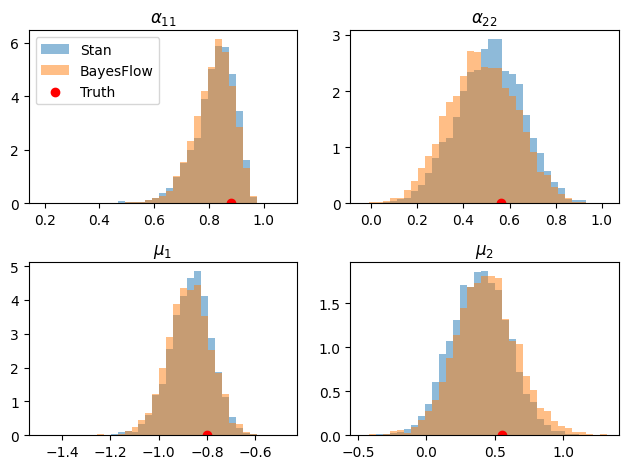

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2)
axs = axs.flatten()

bins = [
    np.linspace(np.min(stan_posterior[:,i])-0.1, np.max(stan_posterior[:,i])+0.1, 36) for i in range(4)
]
for i, par in enumerate(constrained_parameter_names):
    axs[i].hist(stan_posterior[:,i], bins=bins[i], alpha = 0.5, density=True, label="Stan")
    axs[i].hist(bf_posterior[:,i], bins=bins[i], alpha = 0.5, density=True, label="BayesFlow")
    axs[i].scatter(true_params[0,i], 0, color="red", label="Truth")
    axs[i].set_title(par)

axs[0].legend()
fig.tight_layout()

In [10]:
stan_forward   = stan_fit.stan_variables()["filtering"]
stan_backward  = stan_fit.stan_variables()["backward_filtering"]
stan_smoothing = stan_fit.stan_variables()["smoothing"]

In [11]:
one_hot_latents = df['mixture_inputs']['latents'][0][0]
one_hot_latents = np.tile(one_hot_latents, (4000, 1, 1))

losses = {
    "stan": {
        "forward":   amortizer.amortized_mixture.loss(one_hot_latents, stan_forward),
        "backward":  amortizer.amortized_mixture.loss(one_hot_latents, stan_backward),
        "smoothing": amortizer.amortized_mixture.loss(one_hot_latents, stan_smoothing),
    },
    "bf": {
        "forward":   amortizer.amortized_mixture.loss(one_hot_latents, bf_forward),
        "backward":  amortizer.amortized_mixture.loss(one_hot_latents, bf_backward),
        "smoothing": amortizer.amortized_mixture.loss(one_hot_latents, bf_smoothing),
    }
}

In [12]:
stan_forward   = stan_forward[...,1]
stan_backward  = stan_backward[...,1]
stan_smoothing = stan_smoothing[...,1]

bf_forward=bf_forward[...,1]
bf_backward=bf_backward[...,1]
bf_smoothing=bf_smoothing[...,1]

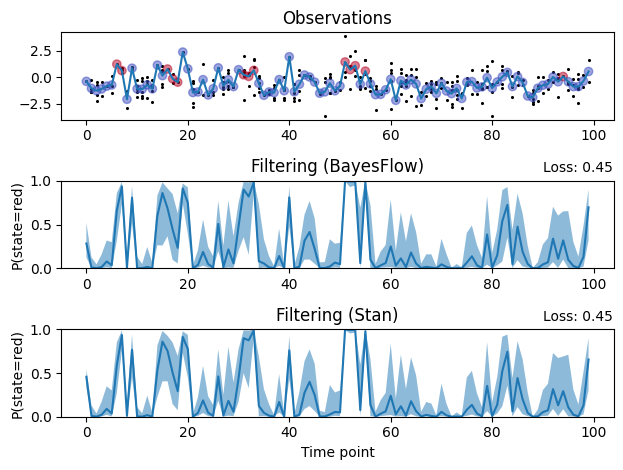

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

means = []
for obs in range(observables.shape[0]):
    x = []
    for rep in range(observables.shape[1]):
        valid = observables[obs,rep,1]
        if valid != 0.0:
            x.append(observables[obs,rep,0])
            ax1.scatter(obs, observables[obs,rep,0], s=1.5, c='black')
    means.append(np.mean(x))

ax1.plot(range(len(observables)), means)
ax1.scatter(range(len(observables)), means, c = latents, cmap='coolwarm', alpha=0.5)
ax1.set_title("Observations")

ax2.plot(range(len(observables)), np.median(bf_forward, axis=0))
ax2.fill_between(
    range(len(observables)),
    np.quantile(bf_forward, q=0.01, axis=0),
    np.quantile(bf_forward, q=0.99, axis=0),
    alpha=0.5
)
ax2.text(len(observables)-10, 1.1, "Loss: {0:.2f}".format(losses["bf"]["forward"]))
ax2.set_title("Filtering (BayesFlow)")
ax2.set_ylabel("P(state=red)")
ax2.set_ylim([0, 1])


ax3.plot(range(len(observables)), np.median(stan_forward, axis=0))
ax3.fill_between(
    range(len(observables)),
    np.quantile(stan_forward, q=0.01, axis=0),
    np.quantile(stan_forward, q=0.99, axis=0),
    alpha=0.5
)
ax3.text(len(observables)-10, 1.1, "Loss: {0:.2f}".format(losses["stan"]["forward"]))
ax3.set_title("Filtering (Stan)")
ax3.set_ylabel("P(state=red)")
ax3.set_xlabel("Time point")
ax3.set_ylim([0, 1])

fig.tight_layout()

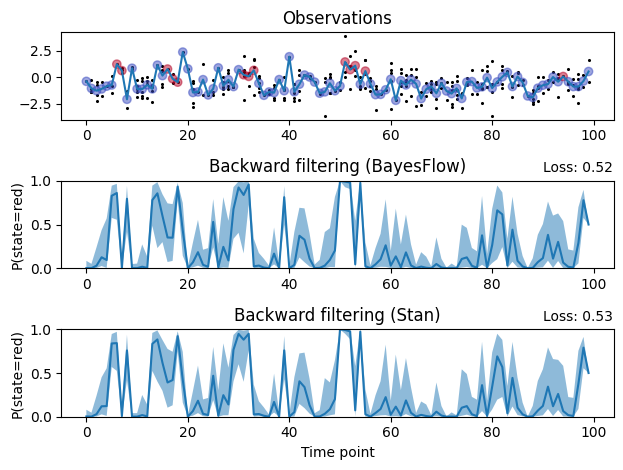

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

means = []
for obs in range(observables.shape[0]):
    x = []
    for rep in range(observables.shape[1]):
        valid = observables[obs,rep,1]
        if valid != 0.0:
            x.append(observables[obs,rep,0])
            ax1.scatter(obs, observables[obs,rep,0], s=1.5, c='black')
    means.append(np.mean(x))

ax1.plot(range(len(observables)), means)
ax1.scatter(range(len(observables)), means, c = latents, cmap='coolwarm', alpha=0.5)
ax1.set_title("Observations")

ax2.plot(range(len(observables)), np.median(bf_backward, axis=0))
ax2.fill_between(
    range(len(observables)),
    np.quantile(bf_backward, q=0.01, axis=0),
    np.quantile(bf_backward, q=0.99, axis=0),
    alpha=0.5
)
ax2.text(len(observables)-10, 1.1, "Loss: {0:.2f}".format(losses["bf"]["backward"]))
ax2.set_title("Backward filtering (BayesFlow)")
ax2.set_ylabel("P(state=red)")
ax2.set_ylim([0, 1])


ax3.plot(range(len(observables)), np.median(stan_backward, axis=0))
ax3.fill_between(
    range(len(observables)),
    np.quantile(stan_backward, q=0.01, axis=0),
    np.quantile(stan_backward, q=0.99, axis=0),
    alpha=0.5
)
ax3.text(len(observables)-10, 1.1, "Loss: {0:.2f}".format(losses["stan"]["backward"]))
ax3.set_title("Backward filtering (Stan)")
ax3.set_ylabel("P(state=red)")
ax3.set_xlabel("Time point")
ax3.set_ylim([0, 1])

fig.tight_layout()

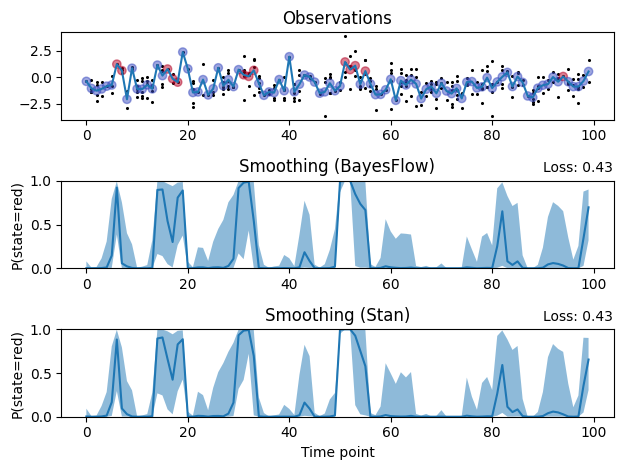

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

means = []
for obs in range(observables.shape[0]):
    x = []
    for rep in range(observables.shape[1]):
        valid = observables[obs,rep,1]
        if valid != 0.0:
            x.append(observables[obs,rep,0])
            ax1.scatter(obs, observables[obs,rep,0], s=1.5, c='black')
    means.append(np.mean(x))

ax1.plot(range(len(observables)), means)
ax1.scatter(range(len(observables)), means, c = latents, cmap='coolwarm', alpha=0.5)
ax1.set_title("Observations")

ax2.plot(range(len(observables)), np.median(bf_smoothing, axis=0))
ax2.fill_between(
    range(len(observables)),
    np.quantile(bf_smoothing, q=0.01, axis=0),
    np.quantile(bf_smoothing, q=0.99, axis=0),
    alpha=0.5
)
ax2.text(len(observables)-10, 1.1, "Loss: {0:.2f}".format(losses["bf"]["smoothing"]))
ax2.set_title("Smoothing (BayesFlow)")
ax2.set_ylabel("P(state=red)")
ax2.set_ylim([0, 1])


ax3.plot(range(len(observables)), np.median(stan_smoothing, axis=0))
ax3.fill_between(
    range(len(observables)),
    np.quantile(stan_smoothing, q=0.01, axis=0),
    np.quantile(stan_smoothing, q=0.99, axis=0),
    alpha=0.5
)
ax3.text(len(observables)-10, 1.1, "Loss: {0:.2f}".format(losses["stan"]["smoothing"]))
ax3.set_title("Smoothing (Stan)")
ax3.set_ylabel("P(state=red)")
ax3.set_xlabel("Time point")
ax3.set_ylim([0, 1])

fig.tight_layout()